In [179]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pyflux as pf
from datetime import datetime, timedelta
import calendar
import re

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML

init_notebook_mode(connected=True)
%matplotlib inline

In [73]:
df = pd.read_csv("daily-minimum-temperatures.csv", skiprows=1, names=["date", "temp"])
df = df[:-1]
df['date'] = pd.to_datetime(df['date'])
df['temp'] = df['temp'].apply(lambda x: re.compile('[^\d.]+').sub('', x)).astype(float)
df.index = df['date']
del df['date']

print(df.shape)
print(df.dtypes)
df.head()

(3650, 1)
temp    float64
dtype: object


,temp
date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [74]:
print("Data are given from {} to {}.".format(df.index.min().date(), df.index.max().date()))
df.describe()

Data are given from 1981-01-01 to 1990-12-31.


,temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [125]:
def plot_ts(df):
    data = [
        go.Scatter(
            x=df.index,
            y=df["temp"]
        )
    ]
    layout = go.Layout(
        yaxis=dict(zeroline=False, title='Temperature')
    )
    iplot({"data": data, "layout": layout})
    
plot_ts(df)

In [76]:
colors = [
    "#660066", "#000066", "#0000ff", "#00ccff", "#00ff00", "#009900", 
    "#003300", "#ff9900", "#ff00ff", "#ff0066", "#ff0000", "#663300"
]

year_range = range(df.index.year.min(), df.index.year.max()+1)
data = []
for y in year_range:
    for m in range(1, 13):
        df_m = df[(df.index.year == y) & (df.index.month == m)]
        data.append(
            go.Scatter(
                x=df_m.index,
                y=df_m["temp"],
                name=calendar.month_abbr[m],
                line={"color": colors[m-1]},
                opacity=0.75,
                showlegend=(y == min(year_range))
            )
        )
iplot({"data": data, "layout": layout})

In [99]:
fig = tools.make_subplots(
    rows=6, 
    cols=2, 
    subplot_titles=[calendar.month_abbr[m] for m in range(1, 13)]
)

for m in range(1, 13):
    df_m = df[df.index.month == m]
    df_m.index = df_m.index.day
    df_m_avg = df_m.groupby(level=0).mean()
    df_m_std = df_m.groupby(level=0).std()
    trace_avg = go.Scatter(
        x=df_m_avg.index,
        y=df_m_avg["temp"],
        name="AVG",
        line={"color": "#000000", "width": 3},
        showlegend=(m==1)
    )
    trace_std_down = go.Scatter(
        x=df_m_avg.index,
        y=df_m_avg["temp"] - df_m_std["temp"],
        fill= None,
        mode='lines',
        line={"color": 'yellow'},
        showlegend=False
    )
    trace_std_up = go.Scatter(
        x=df_m_avg.index,
        y=df_m_avg["temp"] + df_m_std["temp"],
        fill='tonexty',
        mode='lines',
        line={"color": 'yellow'},
        showlegend=False
    )
    fig.append_trace(trace_std_down, (m-1) // 2 + 1, (m-1) % 2 + 1)
    fig.append_trace(trace_std_up, (m-1) // 2 + 1, (m-1) % 2 + 1)
    for i, y in enumerate(year_range):
        df_y = df[(df.index.year == y) & (df.index.month == m)]
        trace = go.Scatter(
            x=df_y.index.day,
            y=df_y["temp"],
            name=y,
            line={"color": colors[i]},
            opacity=0.3,
            showlegend=(m==1)
        )
        fig.append_trace(trace, (m-1) // 2 + 1, (m-1) % 2 + 1)
    fig.append_trace(trace_avg, (m-1) // 2 + 1, (m-1) % 2 + 1)
fig['layout'].update(height=1500)
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]
[ (6,1) x11,y11 ]  [ (6,2) x12,y12 ]



In [126]:
df_w = df.resample('W', how='mean')
plot_ts(df_w)

In [127]:
df_m = df.resample('M', how='mean')
plot_ts(df_m)

In [128]:
df_q = df.resample('Q', how='mean')
plot_ts(df_q)

In [129]:
df_y = df.resample('A', how='mean')
plot_ts(df_y)

In [107]:
def DickeyFullerTest(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
DickeyFullerTest(df['temp'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (5%)              -2.862337
Critical Value (1%)              -3.432153
Critical Value (10%)             -2.567194
dtype: float64


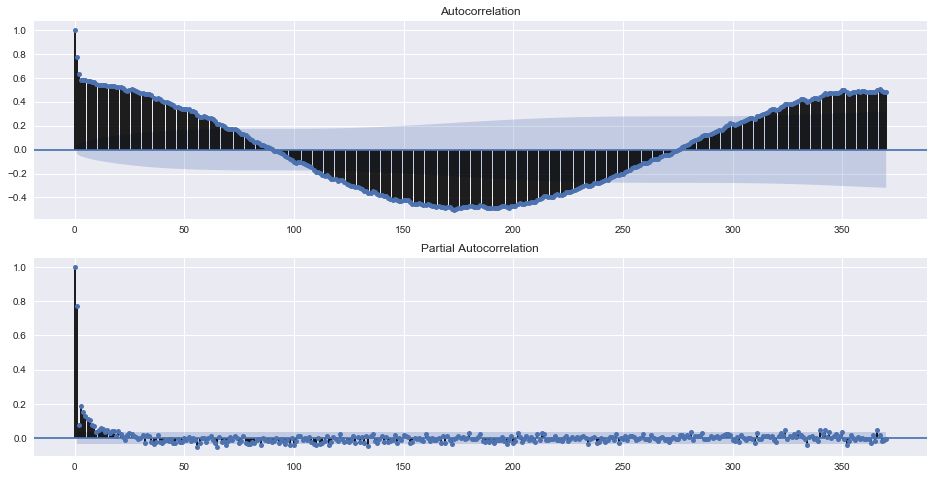

In [199]:
def ACF_PACF(ts, lags=100):
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    plt.show()
    
ACF_PACF(df['temp'], lags=370)

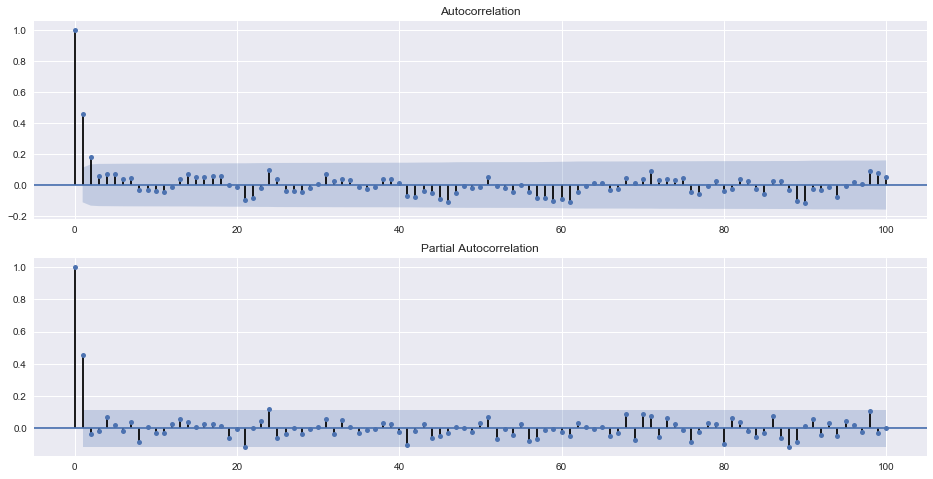

In [120]:
ACF_PACF(df_m['temp'])

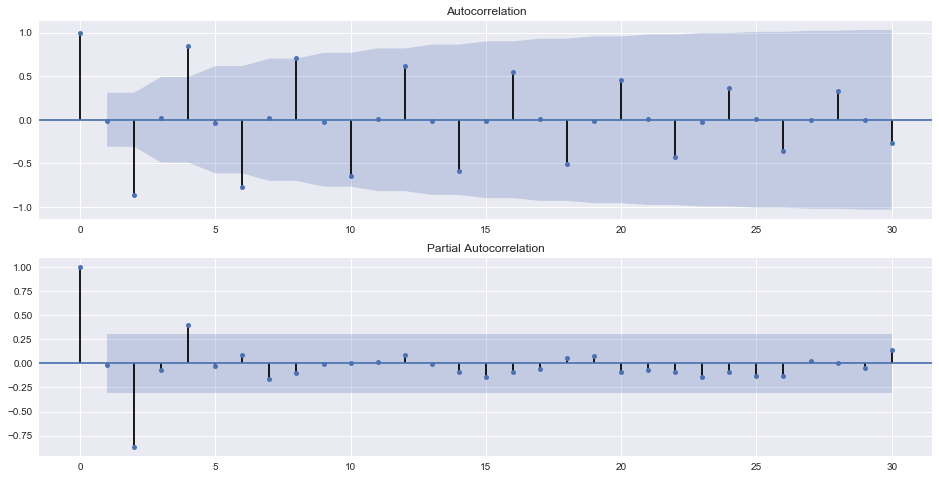

In [133]:
ACF_PACF(df_q['temp'], lags=30)

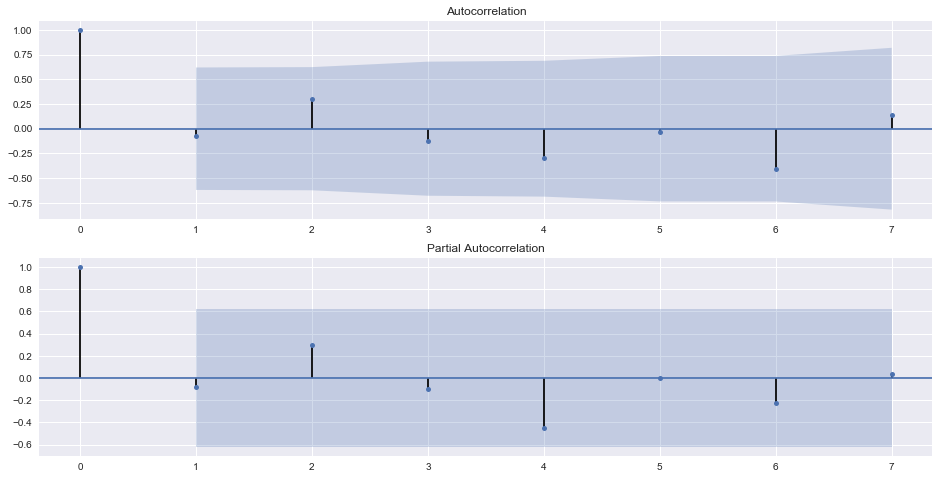

In [135]:
ACF_PACF(df_y['temp'], lags=7)

Results of Dickey-Fuller Test:
Test Statistic                -1.802822e+01
p-value                        2.681562e-30
#Lags Used                     2.400000e+01
Number of Observations Used    3.624000e+03
Critical Value (5%)           -2.862338e+00
Critical Value (1%)           -3.432156e+00
Critical Value (10%)          -2.567195e+00
dtype: float64


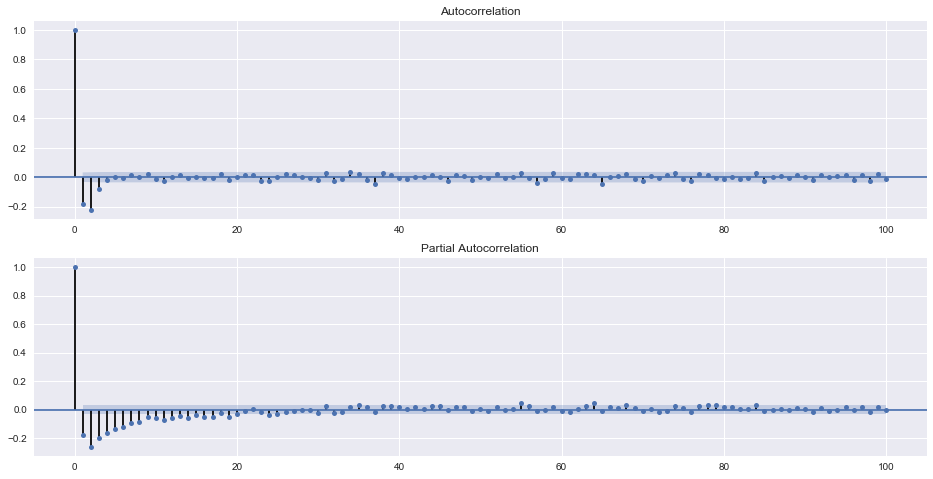

In [146]:
diff1 = np.diff(df['temp'])
DickeyFullerTest(diff1)
iplot({"data": [go.Scatter(x=np.arange(len(diff1)), y=diff1)]})
ACF_PACF(diff1)

Results of Dickey-Fuller Test:
Test Statistic                  -19.036532
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    3279.000000
Critical Value (5%)              -2.862422
Critical Value (1%)              -3.432346
Critical Value (10%)             -2.567239
dtype: float64


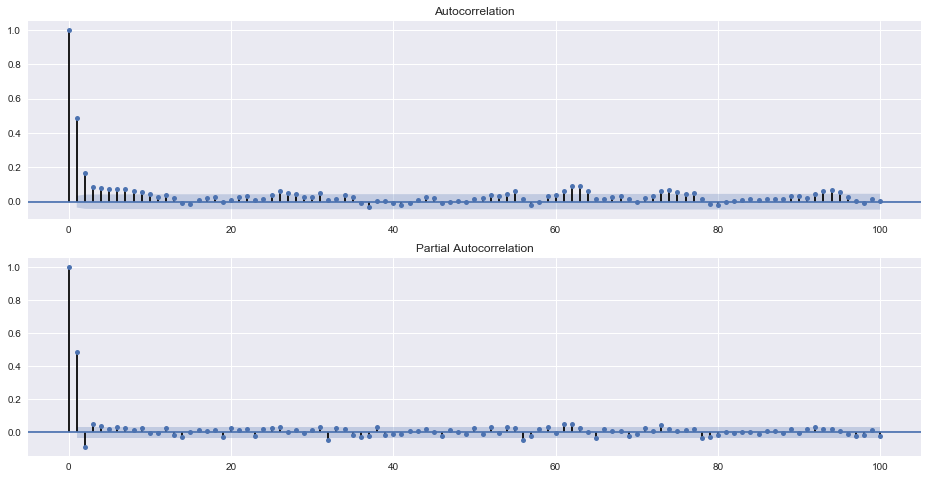

In [147]:
diff365 = np.array([df['temp'][i] - df['temp'][i-365] for i in range(365, len(df['temp']))])
DickeyFullerTest(diff365)
iplot({"data": [go.Scatter(x=np.arange(len(diff365)), y=diff365)]})
ACF_PACF(diff365)

In [197]:
%%time

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2)
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = sm.tsa.ARIMA(df["temp"], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print("best_order =", best_order)
print("best_aic =", best_aic)

best_order = (2, 1, 1)
best_aic = 16780.78537119612
Wall time: 1min 2s


Mean = -0.009044735011140793; Std = 2.4096361194368656


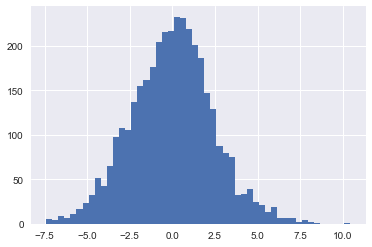

In [175]:
print("Mean = {}; Std = {}".format(best_mdl.resid.mean(), best_mdl.resid.std()))
plt.hist(best_mdl.resid, bins=50)
plt.show()
iplot({"data": [go.Scatter(x=np.arange(len(best_mdl.resid)), y=best_mdl.resid)]})

In [169]:
iplot({"data": [go.Scatter(x=df.index, y=df["temp"]), go.Scatter(x=df.index, y=df["temp"] + best_mdl.resid)]})

In [192]:
forecasts = best_mdl.forecast(steps=31)
forecasts

(array([ 13.09864185,  13.49723706,  13.68230407,  13.72254522,
         13.71855356,  13.71136131,  13.70830838,  13.70772443,
         13.70782993,  13.70795791,  13.70800777,  13.70801594,
         13.70801355,  13.7080113 ,  13.70801049,  13.70801038,
         13.70801043,  13.70801047,  13.70801048,  13.70801049,
         13.70801048,  13.70801048,  13.70801048,  13.70801048,
         13.70801048,  13.70801048,  13.70801048,  13.70801048,
         13.70801048,  13.70801048,  13.70801048]),
 array([ 2.40893568,  2.80375251,  2.87565641,  2.89940574,  2.91927239,
         2.94135278,  2.96496596,  2.98892746,  3.01274048,  3.03631888,
         3.05968667,  3.08286919,  3.10587836,  3.1287192 ,  3.15139498,
         3.17390887,  3.19626418,  3.2184642 ,  3.24051213,  3.26241106,
         3.28416397,  3.30577374,  3.32724316,  3.34857494,  3.36977168,
         3.39083592,  3.41177011,  3.43257663,  3.45325779,  3.47381583,
         3.49425292]),
 array([[  8.37721468,  17.82006901],
 

In [195]:
iplot({
    "data": [
        go.Scatter(x=df.index, y=df["temp"], name="real"), 
        go.Scatter(x=df.index, y=df["temp"] + best_mdl.resid, name="model"),
        go.Scatter(x=pd.date_range('1/1/1991', periods=31, freq='D'), y=forecasts[0], name="forecast"), 
    ]
})

In [202]:
%%time

best_aic = np.inf 
best_order = None
best_order_season = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2)
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            for P in pq_rng:
                for D in d_rng:
                    for Q in pq_rng:
                        try:
                            tmp_mdl = sm.tsa.statespace.SARIMAX(df["temp"], trend='n', order=(i,d,j), seasonal_order=(P,D,Q,365))
                            tmp_aic = tmp_mdl.aic
                            if tmp_aic < best_aic:
                                best_aic = tmp_aic
                                best_order = (i, d, j)
                                best_order_season = (P, D, Q)
                                best_mdl = tmp_mdl
                        except: continue

print("best_order =", best_order)
print("best_order_season =", best_order_season)
print("best_aic =", best_aic)

best_order = None
best_order_season = None
best_aic = inf
Wall time: 4min 28s
